# 1D spectral extraction using aperture photometry on an extended source observation
In this notebook we illustrate how to perform aperture photometry on LVL2 MRS data products (slope detector images). The algorithm is applied to an extended source observation of an 800K blackbody source.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
from distortionMaps import d2cMapping
from shapely.geometry import Point
import shapely.affinity

from numpy import zeros,where
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
lvl2path  = workDir+'FM_data/LVL2/'

Given an MRS observation in a spectral band of choice, the data are reduced from LVL2 to LVL3. We do this here manually.

In [3]:
# Define filename of observation in selected MRS band
band     = '1A'
sci_file = lvl2path+'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits'

In [4]:
# Get data
hdulist_sci   = fits.open(sci_file)
source_signal = hdulist_sci[0].data[0,:,:]

In [5]:
# load distortion map on detector plane
d2cMaps  = d2cMapping(band,cdpDir)
det_dims = (1024,1032)

In [6]:
# load CDPS
fringe_img,photom_img,pixsiz_img,psffits,specres_table = funcs.get_cdps(band,cdpDir,output='img')

Calibration steps from LVL2 to LVL3 data include (1) background subtraction, (2) fringe correction, (3) spectrophotometric calibration, (4) projected pixel size correction.

In [7]:
# reduce LVL2 data to LVL3 data
source_signal_subtrbkg  = source_signal - 0                     # [DN/s/pix_{ij}]
source_signal_divfringe = source_signal_subtrbkg/fringe_img     # [DN/s/pix_{ij}]
source_signal_divphotom = source_signal_divfringe/photom_img    # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)
source_signal_divpixsiz = source_signal_divphotom/pixsiz_img    # [mJy/arcsec^2]

To perform the 1D spectral extraction on detector level, a spectral grid is constructed using the wavelength extension of the MRS distortion maps. An aperture is defined using the spatial extension of the distortion maps.

In [8]:
# create spectral grid on detector
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

In [9]:
# define aperture shape
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = ((0, 0),(1, 1),0)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# save final output as the aperture and calculate the aperture area
aperture = ellr
aperture_area = aperture.area

Each pixel on the detector has a fractional area overlap with the defined aperture. This percentage is used to weigh the signal contribution of a pixel to the total flux of the source in any given spectral bin.

In [10]:
# create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

Pixel weight mapping
0/599 bins processed
100/599 bins processed
200/599 bins processed
300/599 bins processed
400/599 bins processed
500/599 bins processed
599/599 bins processed


Aperture extraction is performed in each spectral bin by multiplying the signal of the contributing pixels by their respective weights. The signals are then summed, and this total is divided (normalized) by the sum of the weights.

In [11]:
# perform 1d aperture extraction
aperture_extracted_signal = funcs.aperture_weighted_photometry_extended_source(source_signal_divpixsiz,weight_map,aperture_area,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms])

Let's plot the extracted 1D spectrum.

<IPython.core.display.Javascript object>


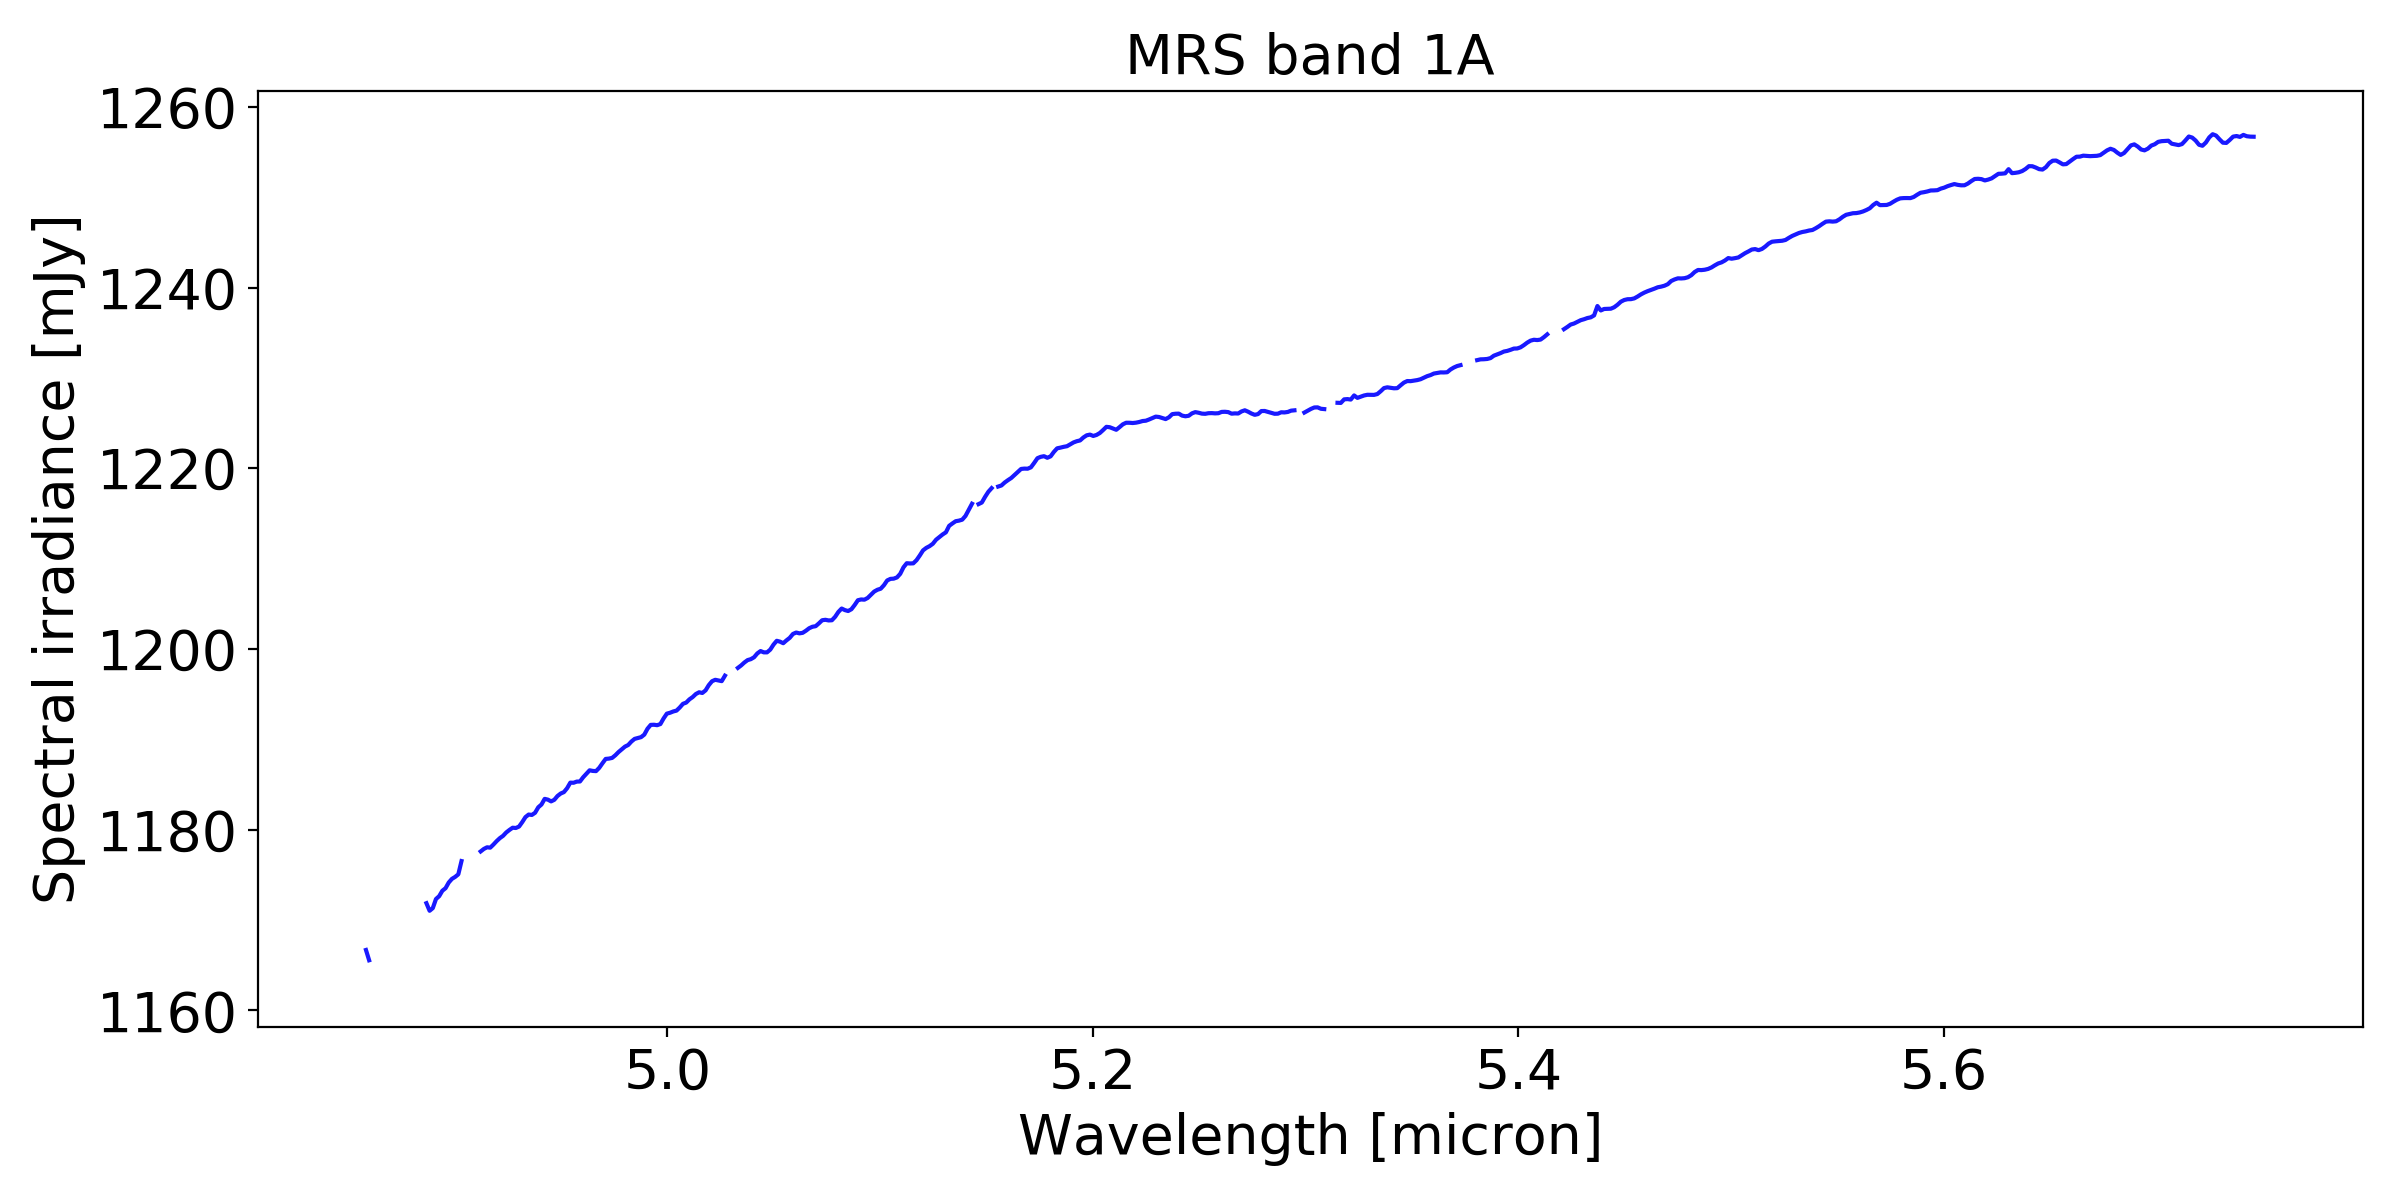

In [12]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
plt.plot(lambcens,aperture_extracted_signal,'b',alpha=0.9)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.title('MRS band {}'.format(band),fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()